In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 15s 192ms/step - loss: 0.2404 - root_mean_squared_error: 0.4903 - val_loss: 0.2047 - val_root_mean_squared_error: 0.4524
Epoch 2/50
53/53 [==============================] - 7s 135ms/step - loss: 0.1057 - root_mean_squared_error: 0.3252 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2378
Epoch 3/50
53/53 [==============================] - 7s 134ms/step - loss: 0.0390 - root_mean_squared_error: 0.1975 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2268
Epoch 4/50
53/53 [==============================] - 8s 158ms/step - loss: 0.0335 - root_mean_squared_error: 0.1832 - val_loss: 0.0455 - val_root_mean_squared_error: 0.2133
Epoch 5/50
53/53 [==============================] - 7s 143ms/step - loss: 0.0302 - root_mean_squared_error: 0.1737 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1992
Epoch 6/50
53/53 [==============================] - 7s 136ms/step - loss: 0.0266 - root_mean_squared_error: 0.1632 - val_loss: 0.0356 - val

53/53 [==============================] - 6s 112ms/step - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1489
Epoch 27/50
53/53 [==============================] - 1s 19ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1501
Epoch 28/50
53/53 [==============================] - 1s 18ms/step - loss: 0.0149 - root_mean_squared_error: 0.1219 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1506
Epoch 29/50
53/53 [==============================] - 8s 149ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1462
Epoch 30/50
53/53 [==============================] - 1s 20ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1474
Epoch 31/50
53/53 [==============================] - 8s 148ms/step - loss: 0.0148 - root_mean_squared_error: 0.1215 - val_loss: 0.0209 - val_root_mean

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.175448334217071 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

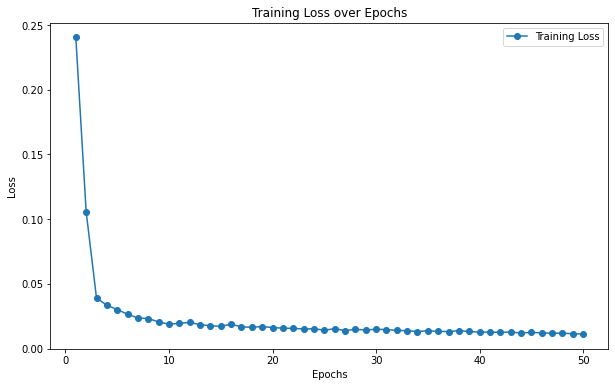

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

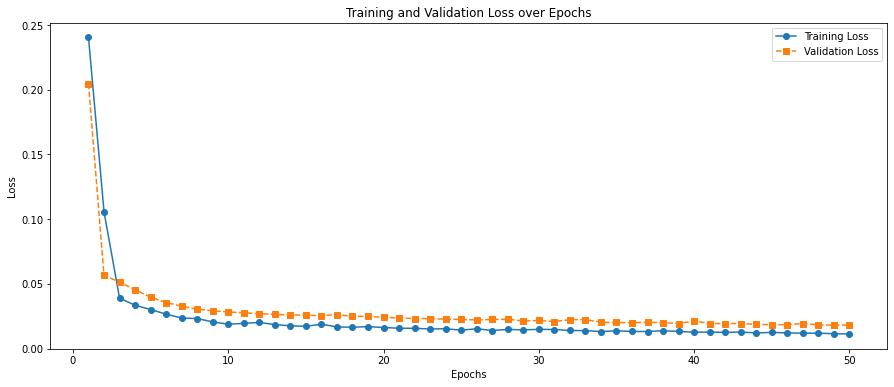

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 7ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.11547542607415065
MAE : 0.09602212700543801


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.035234e+06,1714381.703
1,2.230283e+06,2067343.547
2,2.264996e+06,1856673.675
3,2.168497e+06,1914289.680
4,1.850903e+06,1802244.842
5,1.346566e+06,1202791.069
6,8.678587e+05,752834.272
7,5.779382e+05,451914.219
8,5.430436e+05,439855.813
9,7.301262e+05,807857.307


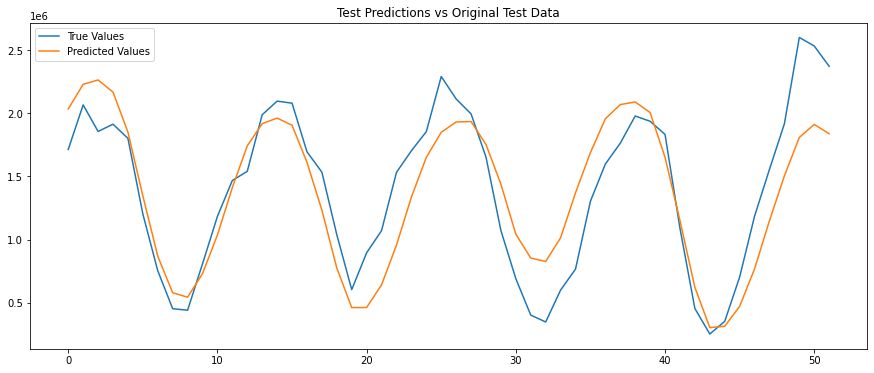

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 10ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

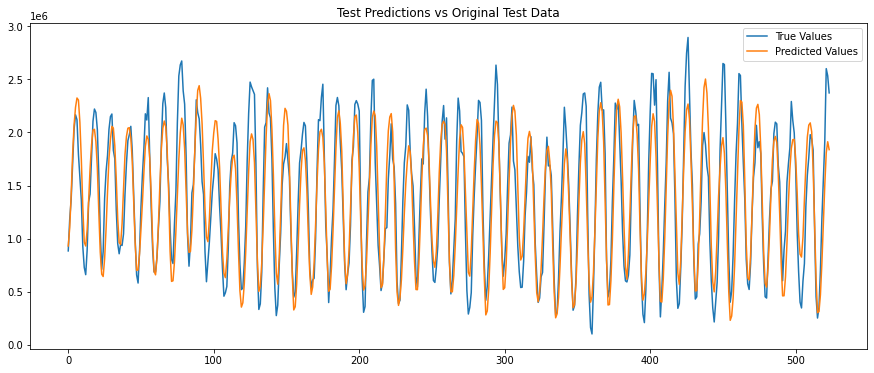

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()